# calculate binary classification on different brain regions

In [10]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
import sys
sys.path.append('../')
from ecog_band.utils import *
import torch
from torch.utils import data as Data
from sklearn.model_selection import GridSearchCV,train_test_split
import torch.nn as nn
import seaborn as sns
import scipy.io as scio
import matplotlib.image as mpimg
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.decomposition import PCA
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp
import seaborn as sns

bands_list = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30),
    'gamma': (30, 70),
    'high gamma':(70,150),
    'else2':(150,min(400/2, 300))
}
HS_list = [45,47,48,50,54,71,76,78,73]
freq_list = [400]
mpl.rcParams['font.size'] =10
regions = ['superiorfrontal', 'rostralmiddlefrontal', 'parstriangularis', 'precentral',
           'parsopercularis', 'supramarginal', 'postcentral', 'superiortemporal',
           'caudalmiddlefrontal', 'inferiorparietal', 'middletemporal', 'lateraloccipital',
           'inferiortemporal', 'bankssts', 'parsorbitalis', 'superiorparietal']


## 1 number of electrodes across different brain regions for all subjects

In [6]:
def Count_electrodes_of_regions(HS_list, freq_list):
    elec_region = {}
    for HS in HS_list:
        anatomy = scio.loadmat(f"/public/DATA/covert_reading/elecs/warped/HS{int(HS)}_elecs_all_warped.mat")['anatomy']

        for freq in freq_list:
            for elec in range(256):
                region = anatomy[elec][3][0]
                if region not in elec_region:
                    elec_region[region] = 0
                elec_region[region] += 1
    return elec_region

def aggregrate_sigelecs_of_regions(HS_list):
    regions = ['superiorfrontal', 'rostralmiddlefrontal', 'parstriangularis', 'precentral', 'parsopercularis', 'supramarginal', 'postcentral', 'superiortemporal', 
               'caudalmiddlefrontal', 'inferiorparietal', 'middletemporal', 'lateraloccipital', 'inferiortemporal', 'bankssts', 'parsorbitalis', 'superiorparietal']

    save_base_path = '/public/DATA/covert_reading/t-test_results/'
    task_sigelecs = np.load(os.path.join(save_base_path, 'sig_elecs_two_tasks.npy'), allow_pickle=True).item()
    allHS_sigeles = {}
    for task in task_sigelecs:
        allHS_sigeles[f'{task}'] = {}
        for band in bands_list.keys():
            elec_region = {region_name:0 for region_name in regions}
            for HS in HS_list:
                bands_sig_elecs = task_sigelecs[task][f'HS{HS}'][band]
                anatomy = scio.loadmat(f"/public/DATA/covert_reading/elecs/warped/HS{int(HS)}_elecs_all_warped.mat")['anatomy']

                for elec in bands_sig_elecs:
                    region = anatomy[elec][3][0]
                    if region not in elec_region:
                        elec_region[region] = 0
                    elec_region[region] += 1

            allHS_sigeles[f'{task}'][band] = elec_region
            
    return allHS_sigeles

def plot_elec_distribution_of_regions(elec_region):
    # 获取脑区和电极数量
    regions = list(elec_region.keys())
    elec_counts = list(elec_region.values())

    # 创建柱状图
    plt.figure(figsize=(10, 8))
    bars = plt.barh(regions, elec_counts, color='skyblue', edgecolor='black')
    
    # 添加数量标注
    for bar, count in zip(bars, elec_counts):
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,  # 在条形末尾标注
                 str(count), va='center', fontsize=10)
    
    # 添加标题和轴标签
    plt.title('Electrode Distribution Across Brain Regions', fontsize=16)
    plt.xlabel('Number of Electrodes', fontsize=14)
    plt.ylabel('Brain Regions', fontsize=14)
    
    # 调整字体大小和图形布局
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.tight_layout()
    
    # 显示图形
    plt.show()

region_abbr = {'superiorfrontal': 'SFG',
             'superiortemporal': 'STG',
             'inferiorparietal': 'AG',
             'rostralmiddlefrontal': 'MFG',
             'parstriangularis': 'pTri',
             'superiorparietal': 'SPL',
             'postcentral': 'PCG',
             'parsopercularis': 'pOp',
             'middletemporal': 'MTG',
             'inferiortemporal': 'IT',
             'supramarginal': 'SMG',
             'lateraloccipital': 'Lo',
             'precentral': 'PC',
             'caudalmiddlefrontal': 'pMFG'}

# 绘制热图
def plot_task_heatmap(task, task_all_sigelecs, bands_list):
    regions = ['superiorfrontal', 'rostralmiddlefrontal', 'parstriangularis', 'precentral', 'parsopercularis', 'supramarginal', 'postcentral', 'superiortemporal', 
               'caudalmiddlefrontal', 'inferiorparietal', 'middletemporal', 'lateraloccipital', 'inferiortemporal', 'bankssts', 'parsorbitalis', 'superiorparietal']

    # 准备存储区域显著比的数据
    heatmap_data = pd.DataFrame(index=regions, columns=bands_list, dtype=float)

    # 遍历频段，填充数据
    for band in bands_list.keys():
        for region in regions:
            total_elec = task_all_sigelecs[band].get(region, 0)
            # print(total_elec)
            heatmap_data.loc[region, band] = total_elec

    # 绘制热图
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        heatmap_data.rename(index=region_abbr),  # 用缩写替换全称
        cmap='viridis',
        annot=True,
        cbar_kws={'label': 'Number of Significant electrodes'},
        linewidths=0.5,
        linecolor='gray'
    )
    plt.title(f"Significant Electrodes for Task: {task}")
    plt.xlabel("Frequency Bands")
    plt.ylabel("Brain Regions")
    plt.tight_layout()
    plt.show()

dict_keys(['supramarginal', 'postcentral', 'precentral', 'caudalmiddlefrontal', 'parsopercularis', 'rostralmiddlefrontal', 'superiorfrontal', 'superiortemporal', 'parstriangularis', 'middletemporal', 'inferiorparietal', 'parsorbitalis', 'lateraloccipital', 'superiorparietal', 'inferiortemporal', 'bankssts'])
{'delta': {'superiorfrontal': 0, 'rostralmiddlefrontal': 0, 'parstriangularis': 0, 'precentral': 1, 'parsopercularis': 0, 'supramarginal': 0, 'postcentral': 0, 'superiortemporal': 0, 'caudalmiddlefrontal': 0, 'inferiorparietal': 0, 'middletemporal': 0, 'lateraloccipital': 0, 'inferiortemporal': 0, 'bankssts': 0, 'parsorbitalis': 0, 'superiorparietal': 0}, 'theta': {'superiorfrontal': 0, 'rostralmiddlefrontal': 1, 'parstriangularis': 0, 'precentral': 1, 'parsopercularis': 1, 'supramarginal': 1, 'postcentral': 3, 'superiortemporal': 0, 'caudalmiddlefrontal': 0, 'inferiorparietal': 0, 'middletemporal': 1, 'lateraloccipital': 0, 'inferiortemporal': 1, 'bankssts': 0, 'parsorbitalis': 0,

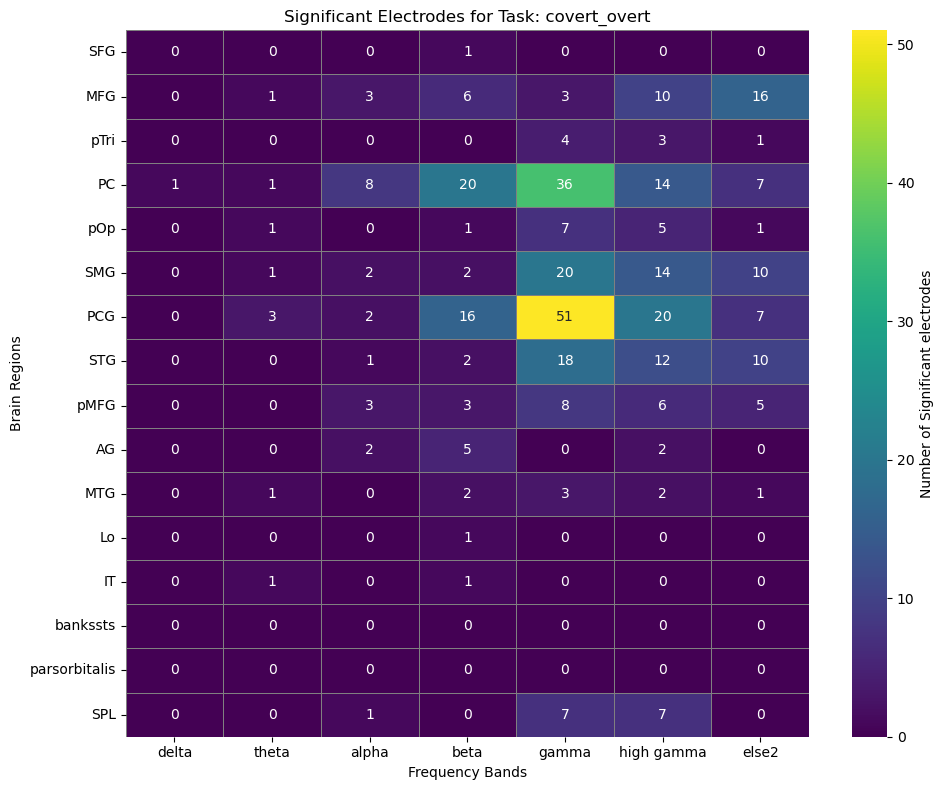

In [7]:
elec_region = Count_electrodes_of_regions(HS_list, freq_list)
print(elec_region.keys())

allHS_sigeles = aggregrate_sigelecs_of_regions(HS_list)
task = 'covert_overt'
allHS_sigelecs_task = allHS_sigeles[task]
print(allHS_sigelecs_task)
plot_task_heatmap(task, allHS_sigelecs_task, bands_list)

## 2 concatenate data on same regions to classify

In [12]:
def cal_region_data_sigelecs(HS, freq_list, bands_sig_elecs):
    # 统计所有被试在涉及到的所有brain region，以及这些brain region的所有电极的数据
    anatomy_covert_data, anatomy_overt_data = {}, {} # [band][region]
    base_data_path = f'/public/DATA/covert_reading/HS_preanalysis_ECoG/HS{HS}/aligned_data'
    anatomy = scio.loadmat(f"/public/DATA/covert_reading/elecs/warped/HS{int(HS)}_elecs_all_warped.mat")['anatomy']

    for freq in freq_list:
        covert_data = np.load(os.path.join(base_data_path, f'covert_allbands_{freq}hz.npy'), allow_pickle=True).item()
        overt_data = np.load(os.path.join(base_data_path, f'overt_allbands_{freq}hz.npy'), allow_pickle=True).item()
        for band in bands_list.keys():
            sig_elecs = bands_sig_elecs[band]
            covert_band_data = covert_data[band]
            overt_band_data = overt_data[band]
            if band not in anatomy_covert_data:
                anatomy_covert_data[band] = {}
                anatomy_overt_data[band] = {}

            for elec in range(covert_band_data.shape[1]):
                if elec not in sig_elecs:
                    continue
                region = anatomy[elec][3][0]
                if region not in anatomy_covert_data[band]:
                    anatomy_covert_data[band][region] = []
                    anatomy_overt_data[band][region] = []
                anatomy_covert_data[band][region].append(covert_band_data[:, elec, :])
                anatomy_overt_data[band][region].append(overt_band_data[:, elec, :])
    # 将列表形式的电极数据堆叠成 (n_samples, n_electrodes, n_times)
    for band in anatomy_covert_data.keys():
        for region in anatomy_covert_data[band].keys():
            # 按电极维度堆叠
            covert_region_data = np.stack(anatomy_covert_data[band][region], axis=1)  # (n_samples, n_electrodes, n_times)
            overt_region_data = np.stack(anatomy_overt_data[band][region], axis=1)  # (n_samples, n_electrodes, n_times)

            # 更新数据
            anatomy_covert_data[band][region] = covert_region_data
            anatomy_overt_data[band][region] = overt_region_data
    
    return anatomy_covert_data, anatomy_overt_data



## 3. define model

In [9]:
class BandErpDataset(Data.Dataset):
    def __init__(self, band_covert_data_all, band_overt_data_all, elec, band):
        '''band_covert_data_all, z_band_read_data_all为所有frequency bands的数据字典，每个band对应一个任务的所有trail的数据
        band_covert_data_all = {band : data(shape = n_trails, n_electrodes, n_timepoints)}
        '''
        super().__init__()
        self.data = [] # 存Ecog数据，shape为（n_samples x n_features)
        self.labels = [] # 存label, shape=（n_samples），cue标记为0，read标记为1
        # load aligned data and plot average signal
        cue_data = band_covert_data_all[band]
        read_data = band_overt_data_all[band] 

        X=np.concatenate((cue_data[:, elec, :], read_data[:, elec, :]),axis=0)
        # X = X.reshape(-1, X.shape[1]*X.shape[2])

        y_cue=np.array([0]*cue_data.shape[0])
        y_read=np.array([1]*read_data.shape[0])
        y=np.concatenate((y_cue,y_read),axis=0)

        self.data = X
        self.labels = y

    def __len__(self):
        return len(self.data)
    
    def get_data_labels(self):
        return self.data, self.labels

    def __getitem__(self, idx):
        # Return a tuple of (data, label) and convert data to a PyTorch tensor
        # print(self.data.shape)
        return torch.tensor(abs(self.data[idx]), dtype=torch.float), torch.tensor(self.labels[idx])
    
class SVMBinClassifier(nn.Module):
    def __init__(self):
        # tuned_parameters = [{'kernel': ['linear'], 'C': [0.1, 1], 'gamma': [0.01]}]
        # self.model = GridSearchCV(SVC(), tuned_parameters, scoring='accuracy', n_jobs=1)
        self.model = SVC(C=0.1, kernel='sigmoid')
        self.pca = PCA(n_components=0.95)
    
    def train(self, x_train, y_train):
        X_train_pca = self.pca.fit_transform(x_train)
        self.model.fit(X_train_pca, y_train)
        # plt_learning_curve(self.model, X_train_pca, y_train, cv=5)
        # best_params = self.model.best_params_
        # return best_params
    
    def predict(self, x_test):
        X_test_pca = self.pca.transform(x_test)
        return self.model.predict(X_test_pca)
    
    def evaluate(self, X_test, y_test):
        # X_test_pca = self.pca.transform(X_test)
        y_pred = self.predict(X_test)
        # y_pred = cross_val_predict(self.model, X=X_test_pca, y=y_test, cv=5)
        return y_pred

## 4. do classify

In [11]:
def BN_diff_region(anatomy_covert_data, anatomy_overt_data, HS):
    # 分类器和结果存储
    region_classification_results = {}
    save_acc_dir = f'/public/DATA/covert_reading/bands_acc/HS{HS}'

    # 遍历每个频段和区域进行分类
    for band in bands_list.keys():
        for region in anatomy_covert_data[band].keys():
            # 提取 covert 和 overt 数据
            covert_region_data = anatomy_covert_data[band][region]
            overt_region_data = anatomy_overt_data[band][region]
        
            X_covert = covert_region_data.reshape(covert_region_data.shape[0], -1)  # covert_region_data 的形状为 (num_samples, num_electrodes * time_steps)
            X_overt = overt_region_data.reshape(overt_region_data.shape[0], -1)    # overt_region_data 的形状为 (num_samples, num_electrodes * time_steps)
            # print(X_covert.shape, X_overt.shape)
            
            X = np.concatenate((X_covert, X_overt))
            y = np.array([0] * covert_region_data.shape[0] + [1] * overt_region_data.shape[0])
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

            svm = SVMBinClassifier()
            svm.train(X_train, y_train)

            y_pred = svm.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)

            # print(f'Accuracy for region {region} on {band} band: {accuracy:.2f}')
            region_classification_results[(band, region)] = accuracy

    np.save(os.path.join(save_acc_dir, 'anatomical_acc.npy'), region_classification_results)
    return region_classification_results

    
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot(region_classification_results, HS):
    # 将数据转换为 DataFrame
    results_df = pd.DataFrame.from_dict(region_classification_results, orient='index', columns=['Accuracy'])
    results_df.index = pd.MultiIndex.from_tuples(results_df.index, names=["Band", "Region"])
    results_df = results_df.reset_index()

    # 构建完整的 DataFrame，填充所有可能的 Band 和 Region
    full_index = pd.MultiIndex.from_product([bands_list, regions], names=["Band", "Region"])
    results_df = results_df.set_index(["Band", "Region"]).reindex(full_index).reset_index()

    # 透视数据，使其适合热图显示
    heatmap_data = results_df.pivot(index='Region', columns='Band', values='Accuracy')

    # 绘制热图
    plt.figure(figsize=(12, 8))
    plt.imshow(heatmap_data, cmap='viridis', aspect='auto')

    # 添加颜色条
    plt.colorbar(label='Accuracy')

    # 设置标签和标题
    plt.xticks(ticks=np.arange(len(heatmap_data.columns)), labels=heatmap_data.columns, rotation=45, ha='right')
    plt.yticks(ticks=np.arange(len(heatmap_data.index)), labels=heatmap_data.index)
    plt.xlabel('Frequency Band')
    plt.ylabel('Brain Region')
    plt.title(f'Classification Accuracy Heatmap for Each Band and Region(sigelecs) - {HS}')

    plt.tight_layout()
    plt.show()

In [14]:
save_base_path = '/public/DATA/covert_reading/t-test_results/'
task_sigelecs = np.load(os.path.join(save_base_path, 'sig_elecs_two_tasks.npy'), allow_pickle=True).item()
task = 'covert_overt'

for HS in HS_list:
    save_acc_dir = f'/public/DATA/covert_reading/bands_acc/HS{HS}'
    # 只能单个被试处理了，因为不同被试的sample数量不同，无法拼接
    anatomy_cue_data, anatomy_read_data = cal_region_data_sigelecs(HS, freq_list, task_sigelecs[task][f'HS{HS}'])
    region_classification_results = BN_diff_region(anatomy_cue_data, anatomy_read_data, HS)
    np.save(os.path.join(save_acc_dir, f'sigelecs_anatomical_acc.npy'), region_classification_results)


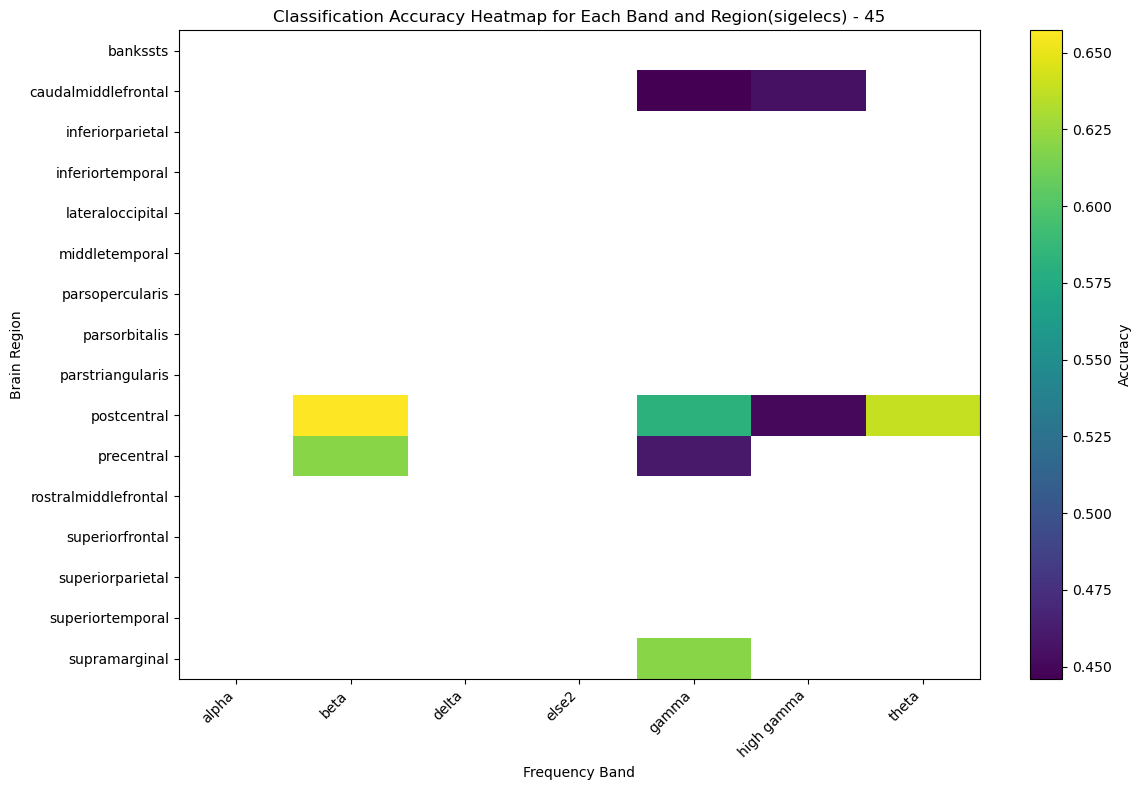

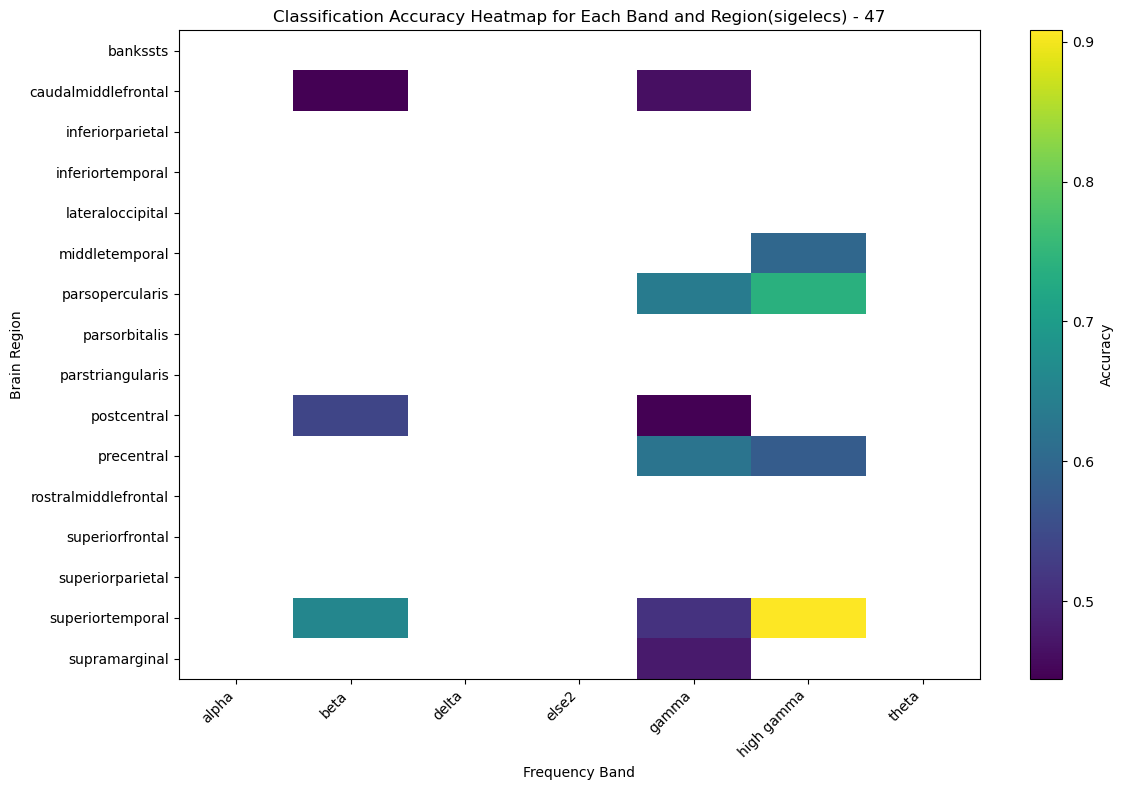

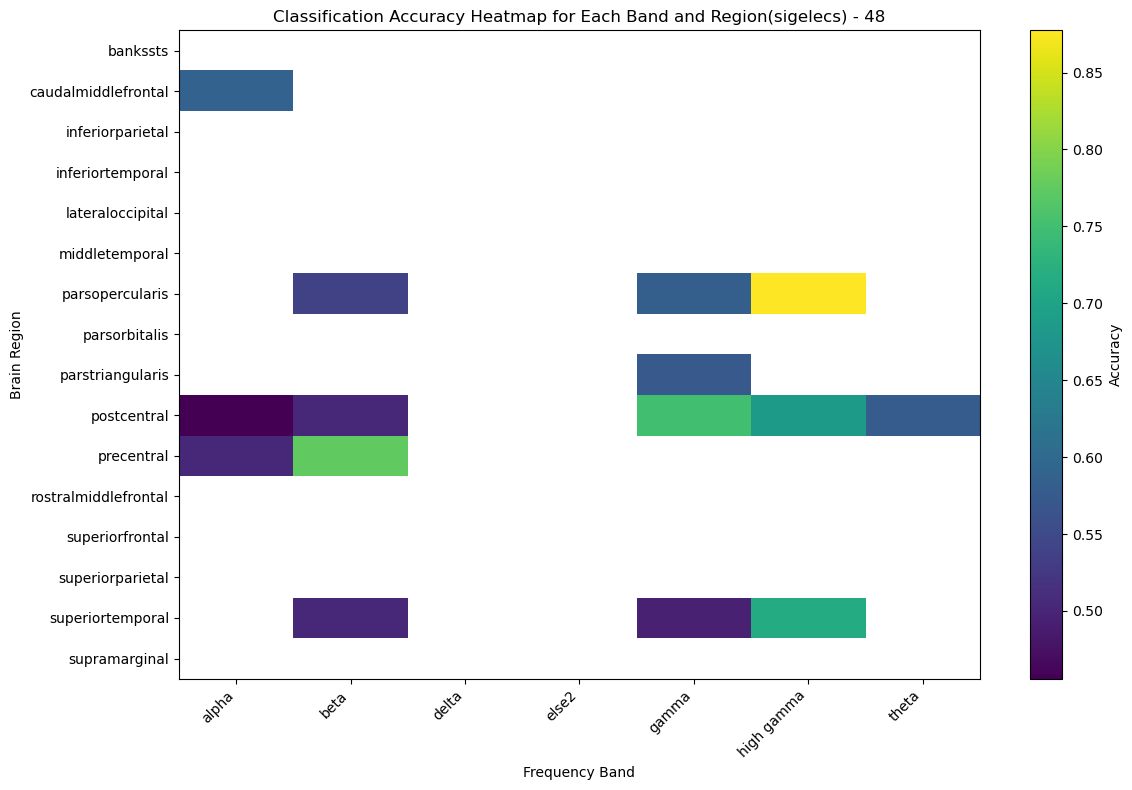

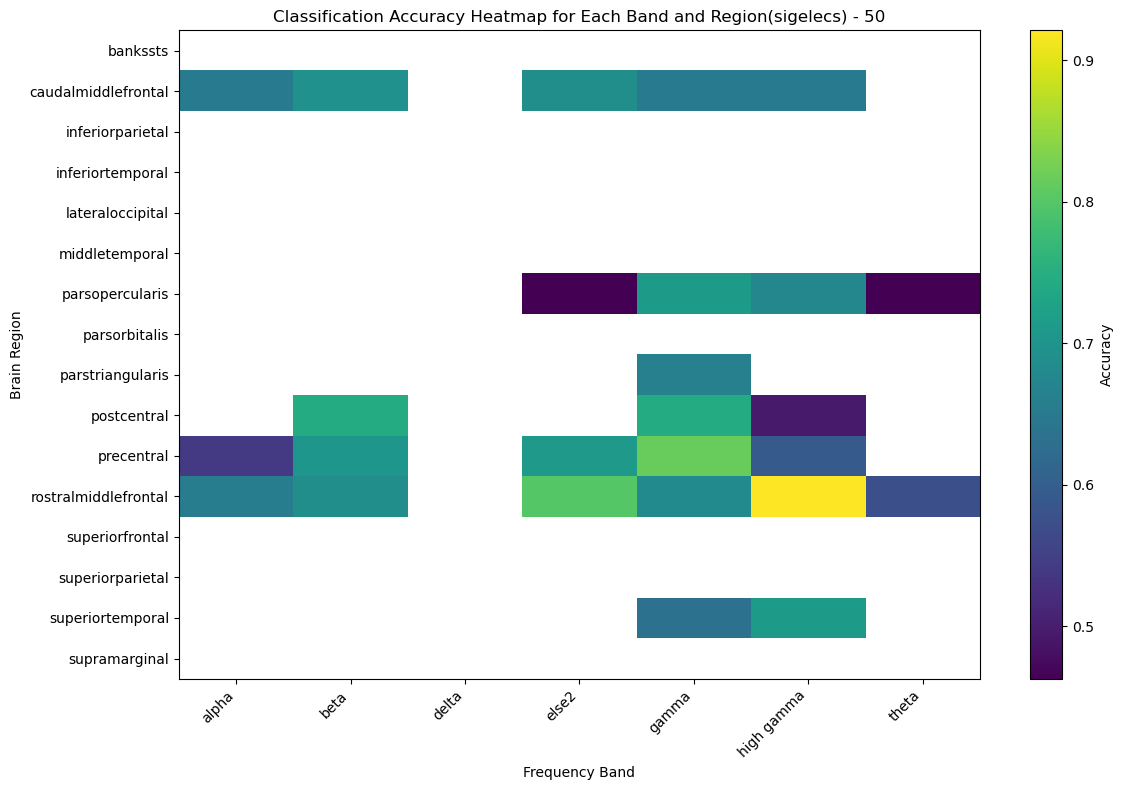

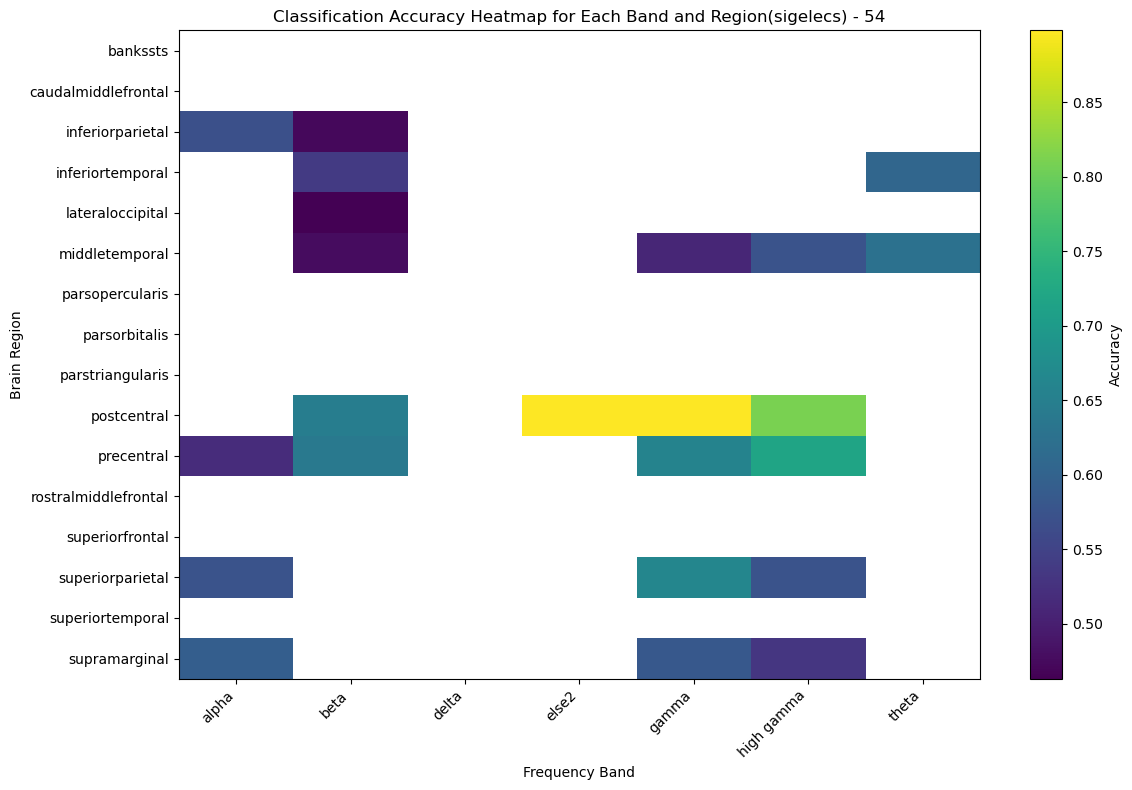

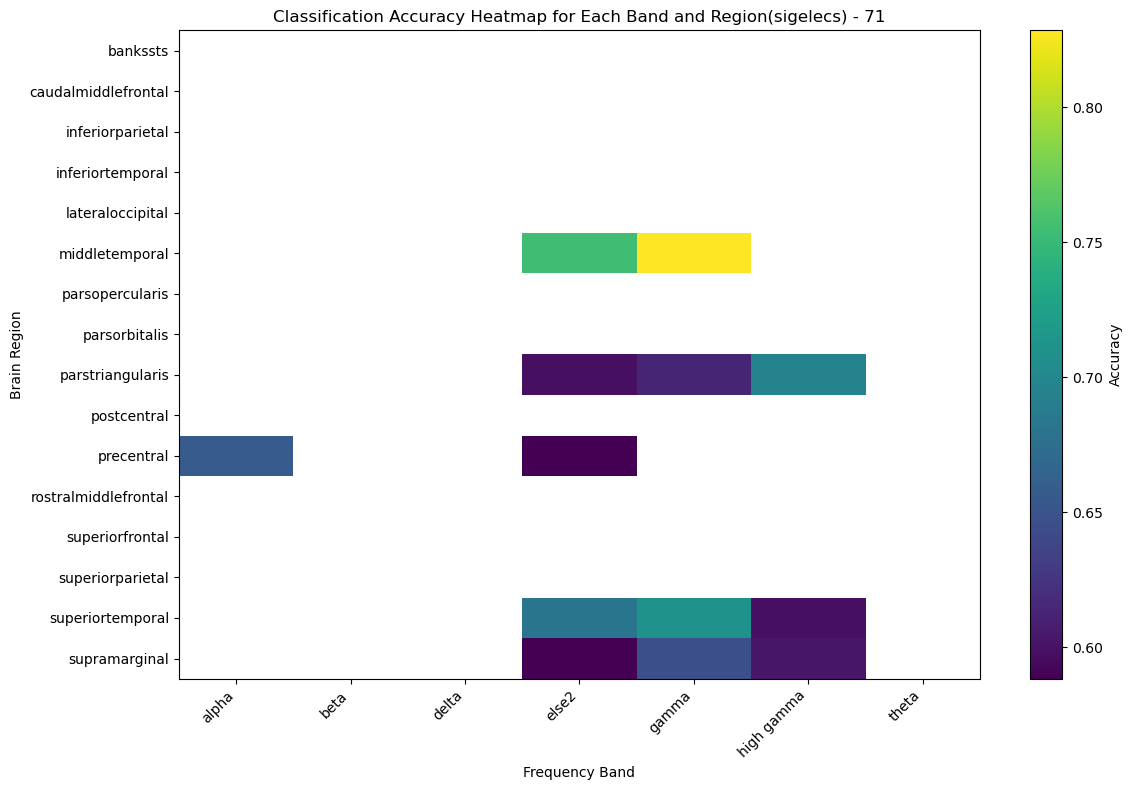

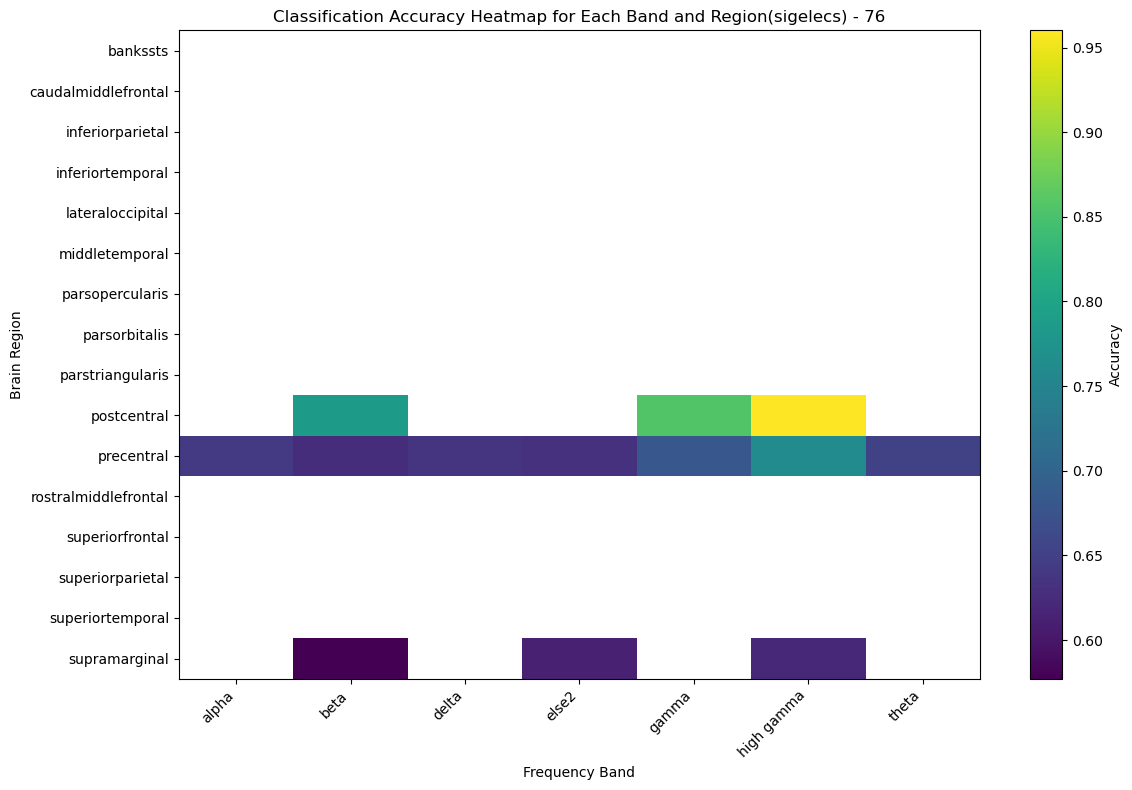

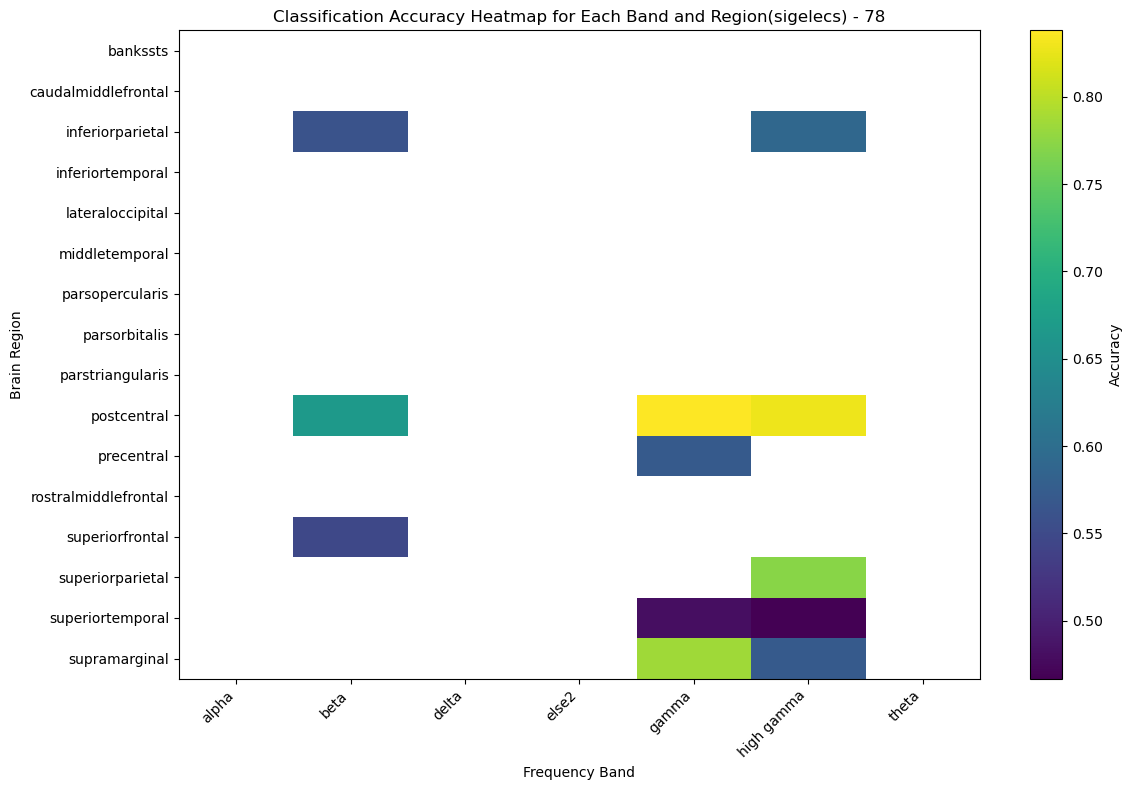

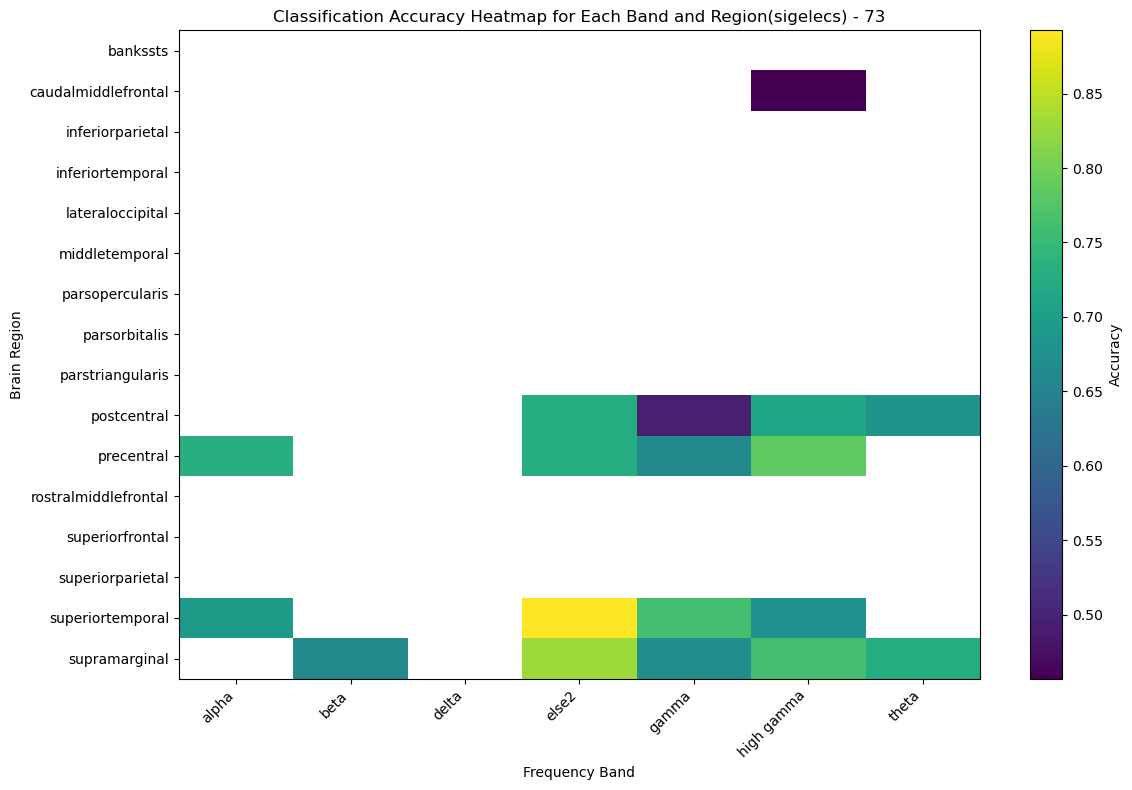

In [15]:
for HS in HS_list:
    save_acc_dir = f'/public/DATA/covert_reading/bands_acc/HS{HS}/'
    region_classification_results = np.load(os.path.join(save_acc_dir, 'sigelecs_anatomical_acc.npy'), allow_pickle=True).item()
    plot(region_classification_results, HS)
    # print(anatomy_covert_data['theta'].keys())

## 5. calculate mean of brain area across all subjects

In [17]:
def plot(region_classification_results):
    # 将数据转换为 DataFrame
    results_df = pd.DataFrame.from_dict(region_classification_results, orient='index', columns=['Accuracy'])
    results_df.index = pd.MultiIndex.from_tuples(results_df.index, names=["Band", "Region"])
    results_df = results_df.reset_index()

    # 透视数据，使其适合热图显示
    heatmap_data = results_df.pivot(index='Region', columns='Band', values='Accuracy')

    # 绘制热图
    plt.figure(figsize=(12, 8))
    plt.imshow(heatmap_data, cmap='viridis', aspect='auto')

    # 添加颜色条
    plt.colorbar(label='Accuracy')

    # 设置标签和标题
    plt.xticks(ticks=np.arange(len(heatmap_data.columns)), labels=heatmap_data.columns, rotation=45, ha='right')
    plt.yticks(ticks=np.arange(len(heatmap_data.index)), labels=heatmap_data.index)
    plt.xlabel('Frequency Band')
    plt.ylabel('Brain Region')
    plt.title(f'Classification Accuracy Heatmap for Each Band and Region')

    plt.tight_layout()
    plt.show()

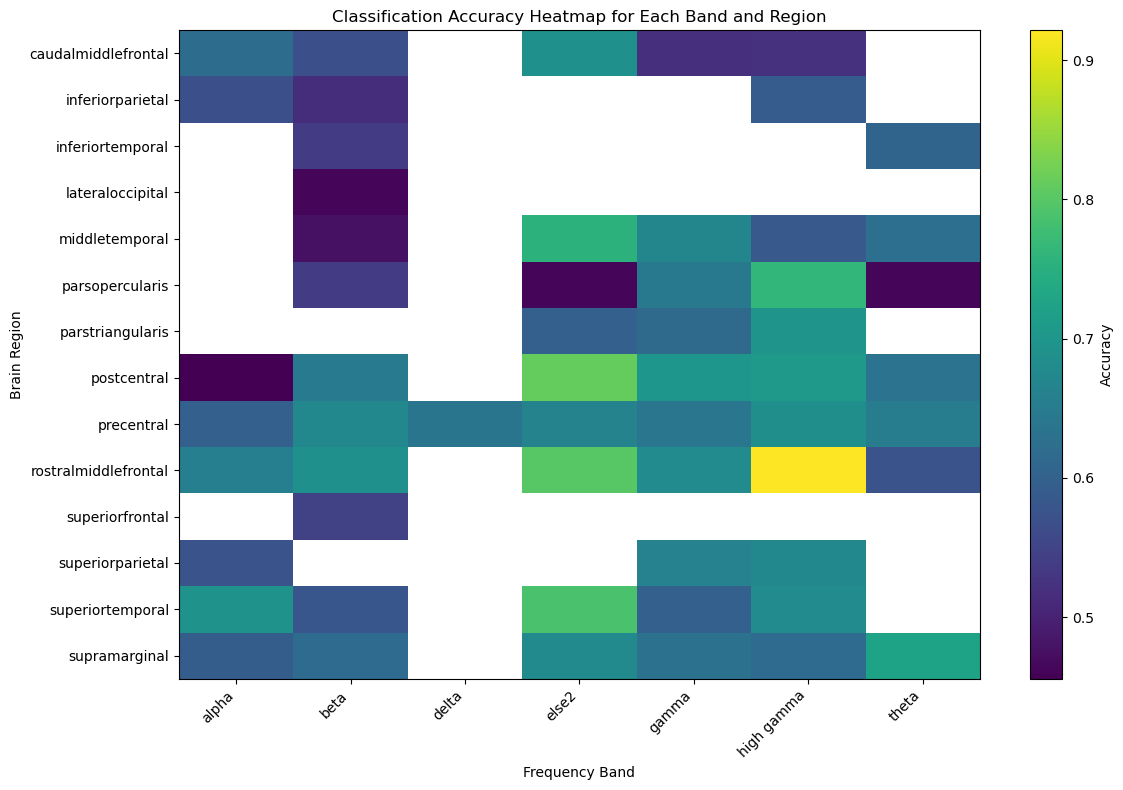

In [18]:
# elec_region = Count_electrodes_of_regions(HS_list, freq_list)

band_region_accs = {}
for HS in HS_list:
    save_acc_dir = f'/public/DATA/covert_reading/bands_acc/HS{HS}'
    region_classification_results = np.load(os.path.join(save_acc_dir, 'sigelecs_anatomical_acc.npy'), allow_pickle=True).item()
    for (band, region), accuracy in region_classification_results.items():
        if (band, region) not in band_region_accs:
            band_region_accs[(band, region)] = []
        band_region_accs[(band, region)].append(accuracy)
    

mean_band_region_acc = {}
for (band, region) in band_region_accs.keys():
    if (band, region) not in mean_band_region_acc:
        mean_band_region_acc[(band, region)] = 0
    mean_band_region_acc[(band, region)] = np.mean(band_region_accs[(band, region)])
    # print(f'({band}, {region} accuracy = {band_region_accs[(band, region)]})')

plot(mean_band_region_acc)